In [ ]:
#Just some preprocessing of the data. Downloading the required test and Train data and putting them in the right place.

!unzip /content/data.zip >> unzip.log

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

# Path to the data folder
data_folder = '/content/data'

image_size = (224, 224)
batch_size = 48

train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.1
)

train_generator = train_datagen.flow_from_directory(
    data_folder,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    data_folder,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

base_model = MobileNet(include_top=False, input_shape=(224, 224, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

epochs = 18
model.fit(train_generator, epochs=epochs, validation_data=validation_generator)

model.save('trained_model.h5')


Found 174 images belonging to 7 classes.
Found 16 images belonging to 7 classes.
Epoch 1/20
4/4 [==============================] - 67s 16s/step - loss: 0.8164 - accuracy: 0.7529 - val_loss: 0.8038 - val_accuracy: 0.7500
Epoch 2/20
4/4 [==============================] - 40s 10s/step - loss: 0.0148 - accuracy: 1.0000 - val_loss: 1.0459 - val_accuracy: 0.7500
Epoch 3/20
4/4 [==============================] - 40s 10s/step - loss: 7.4801e-04 - accuracy: 1.0000 - val_loss: 1.2062 - val_accuracy: 0.7500
Epoch 4/20
4/4 [==============================] - 39s 9s/step - loss: 3.9221e-04 - accuracy: 1.0000 - val_loss: 1.0233 - val_accuracy: 0.8125
Epoch 5/20
4/4 [==============================] - 40s 10s/step - loss: 1.4772e-04 - accuracy: 1.0000 - val_loss: 0.9255 - val_accuracy: 0.8125
Epoch 6/20
4/4 [==============================] - 43s 10s/step - loss: 3.1400e-04 - accuracy: 1.0000 - val_loss: 1.1044 - val_accuracy: 0.8125
Epoch 7/20
4/4 [==============================] - 40s 11s/step - loss:

In [ ]:
# Convert the model to TFLite format
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the TFLite model to a file
with open('classifier.tflite', 'wb') as f:
    f.write(tflite_model)


In [ ]:
import cv2

def split_image(input_path, output_paths):
    piece_count = len(output_paths)  # Number of output pieces
    image = cv2.imread(input_path)  # Read the input image

    # Check if the image and output paths are valid
    if image is None or len(output_paths) != piece_count:
        print("Invalid image or output paths")
        return

    # Get the dimensions of the image
    image_height, image_width, _ = image.shape

    # Calculate the width and height of each piece
    piece_width = image_width // piece_count
    piece_height = image_height

    # Split the image into horizontal pieces and save each piece
    for i in range(piece_count):
        start_x = i * piece_width
        end_x = (i + 1) * piece_width
        piece = image[:, start_x:end_x]
        cv2.imwrite(output_paths[i], piece)

    print("Image split into {} pieces successfully.".format(piece_count))


In [ ]:
import tensorflow as tf
import numpy as np
import time


interpreter = tf.lite.Interpreter(model_path='/content/classifier.tflite')
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()


def classify_image(img_path):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
    x = tf.keras.preprocessing.image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = tf.keras.applications.mobilenet.preprocess_input(x)

    interpreter.set_tensor(input_details[0]['index'], x)

    interpreter.invoke()

    output = interpreter.get_tensor(output_details[0]['index'])

    class_names = ['bar', 'bell', 'cherry', 'clown', 'elephant', 'grape', 'z']

    class_indices = np.argmax(output, axis=1)
    class_labels = [class_names[i] for i in class_indices]

    probabilities = np.max(output, axis=1)

    predicted_labels = list(zip(class_labels, probabilities))
    return {"accuracy": predicted_labels[0][1], "class_index": int(class_indices), "class": predicted_labels[0][0]}


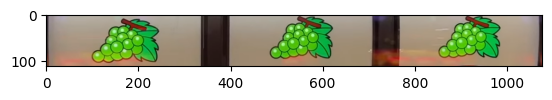

Image split into 3 pieces successfully.
{'accuracy': 0.9999726, 'class_index': 5, 'class': 'grape'}
{'accuracy': 0.99996364, 'class_index': 5, 'class': 'grape'}
{'accuracy': 0.9999615, 'class_index': 5, 'class': 'grape'}


 The icons in the row are the same.


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


def predict(img_path):
    image = mpimg.imread(img_path)
    plt.imshow(image)
    plt.show()
    output_paths = ['/tmp/split1.png', '/tmp/split2.png', '/tmp/split3.png']
    split_image(img_path, output_paths)
    class_index = []
    for img in output_paths:
        out = classify_image(img)
        class_index.append(out['class_index'])
        print(out)

    if class_index[0] == class_index[1] and class_index[1] == class_index[2]:
        print("\n\n The icons in the row are the same.")

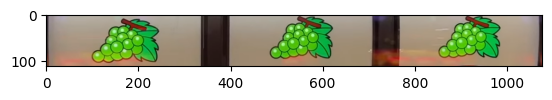

Image split into 3 pieces successfully.
{'accuracy': 0.9999726, 'class_index': 5, 'class': 'grape'}
{'accuracy': 0.99996364, 'class_index': 5, 'class': 'grape'}
{'accuracy': 0.9999615, 'class_index': 5, 'class': 'grape'}


 The icons in the row are the same.


In [ ]:
predict("/10.png")

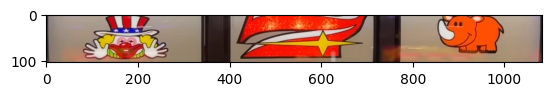

Image split into 3 pieces successfully.
{'accuracy': 0.91868657, 'class_index': 3, 'class': 'clown'}
{'accuracy': 0.9935882, 'class_index': 6, 'class': 'z'}
{'accuracy': 0.9841595, 'class_index': 4, 'class': 'elephant'}


In [ ]:
predict("/9.png")

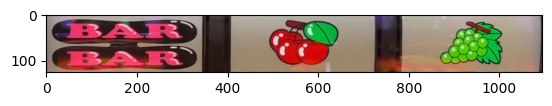

Image split into 3 pieces successfully.
{'accuracy': 0.9999201, 'class_index': 0, 'class': 'bar'}
{'accuracy': 0.74575114, 'class_index': 5, 'class': 'grape'}
{'accuracy': 0.99988544, 'class_index': 5, 'class': 'grape'}


In [ ]:
predict("/8.png")

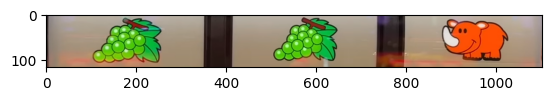

Image split into 3 pieces successfully.
{'accuracy': 0.99995697, 'class_index': 5, 'class': 'grape'}
{'accuracy': 0.999967, 'class_index': 5, 'class': 'grape'}
{'accuracy': 0.98116875, 'class_index': 4, 'class': 'elephant'}


In [ ]:
predict("/7.png")

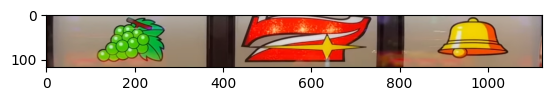

Image split into 3 pieces successfully.
{'accuracy': 0.99998176, 'class_index': 5, 'class': 'grape'}
{'accuracy': 0.996347, 'class_index': 6, 'class': 'z'}
{'accuracy': 0.9999684, 'class_index': 1, 'class': 'bell'}


In [ ]:
predict("/6.png")

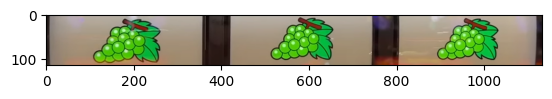

Image split into 3 pieces successfully.
{'accuracy': 0.9999552, 'class_index': 5, 'class': 'grape'}
{'accuracy': 0.99995804, 'class_index': 5, 'class': 'grape'}
{'accuracy': 0.99989533, 'class_index': 5, 'class': 'grape'}


 The icons in the row are the same.


In [ ]:
predict("/5.png")

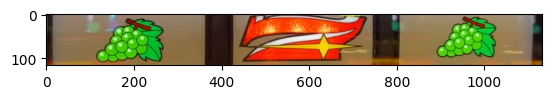

Image split into 3 pieces successfully.
{'accuracy': 0.9999901, 'class_index': 5, 'class': 'grape'}
{'accuracy': 0.997609, 'class_index': 6, 'class': 'z'}
{'accuracy': 0.99968445, 'class_index': 5, 'class': 'grape'}


In [ ]:
predict("/4.png")

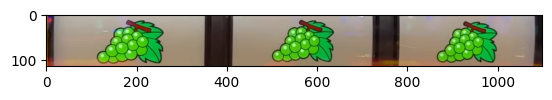

Image split into 3 pieces successfully.
{'accuracy': 0.9999883, 'class_index': 5, 'class': 'grape'}
{'accuracy': 0.9999461, 'class_index': 5, 'class': 'grape'}
{'accuracy': 0.9999442, 'class_index': 5, 'class': 'grape'}


 The icons in the row are the same.


In [ ]:
predict("/3.png")

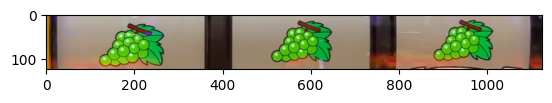

Image split into 3 pieces successfully.
{'accuracy': 0.99995947, 'class_index': 5, 'class': 'grape'}
{'accuracy': 0.9999093, 'class_index': 5, 'class': 'grape'}
{'accuracy': 0.9998791, 'class_index': 5, 'class': 'grape'}


 The icons in the row are the same.


In [ ]:
predict("/2.png")

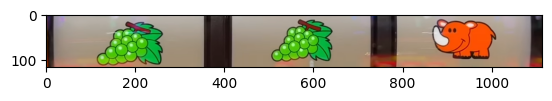

Image split into 3 pieces successfully.
{'accuracy': 0.9999777, 'class_index': 5, 'class': 'grape'}
{'accuracy': 0.9999571, 'class_index': 5, 'class': 'grape'}
{'accuracy': 0.97959423, 'class_index': 4, 'class': 'elephant'}


In [ ]:
predict("/1.png")